In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import logging
import random

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
# Define the dataset path with error handling
try:
    dataset_base_path = '../dataset'
    if not os.path.exists(dataset_base_path):
        raise FileNotFoundError(f"Dataset path '{dataset_base_path}' does not exist")
    
    dirs = os.listdir(dataset_base_path)
    print(f"Available directories: {dirs}")
except Exception as e:
    logger.error(f"Error loading dataset directory: {str(e)}")
    raise

Available directories: ['Apple', 'Bell Pepper', 'Cherry', 'Corn (Maize)', 'Grape', 'Peach', 'Potato', 'Strawberry', 'Tomato']


In [4]:
# Select and validate the target directory
try:
    selected_dir = 'Grape'
    selected_dir_path = os.path.join(dataset_base_path, selected_dir)
    
    if not os.path.exists(selected_dir_path):
        raise FileNotFoundError(f"Selected directory '{selected_dir}' does not exist")
    
    # List all disease categories
    disease_categories = [d for d in os.listdir(selected_dir_path) 
                         if os.path.isdir(os.path.join(selected_dir_path, d))]
    
    print(f"Found {len(disease_categories)} disease categories: {disease_categories}")
except Exception as e:
    logger.error(f"Error accessing selected directory: {str(e)}")
    raise

Found 4 disease categories: ['Black Rot', 'Esca (Black Measles)', 'Healthy', 'Leaf Blight']


In [5]:
# Function to display sample images from each category
def display_sample_images(directory_path, categories, samples_per_category=3):
    """Display sample images from each category."""
    plt.figure(figsize=(15, 5 * len(categories)))
    
    for i, category in enumerate(categories):
        category_path = os.path.join(directory_path, category)
        image_files = os.listdir(category_path)
        
        # Select random samples
        sample_files = random.sample(image_files, min(samples_per_category, len(image_files)))
        
        for j, file in enumerate(sample_files):
            img_path = os.path.join(category_path, file)
            img = Image.open(img_path).convert('RGB')
            
            plt.subplot(len(categories), samples_per_category, i * samples_per_category + j + 1)
            plt.imshow(img)
            plt.title(f"{category}\n{img.size}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

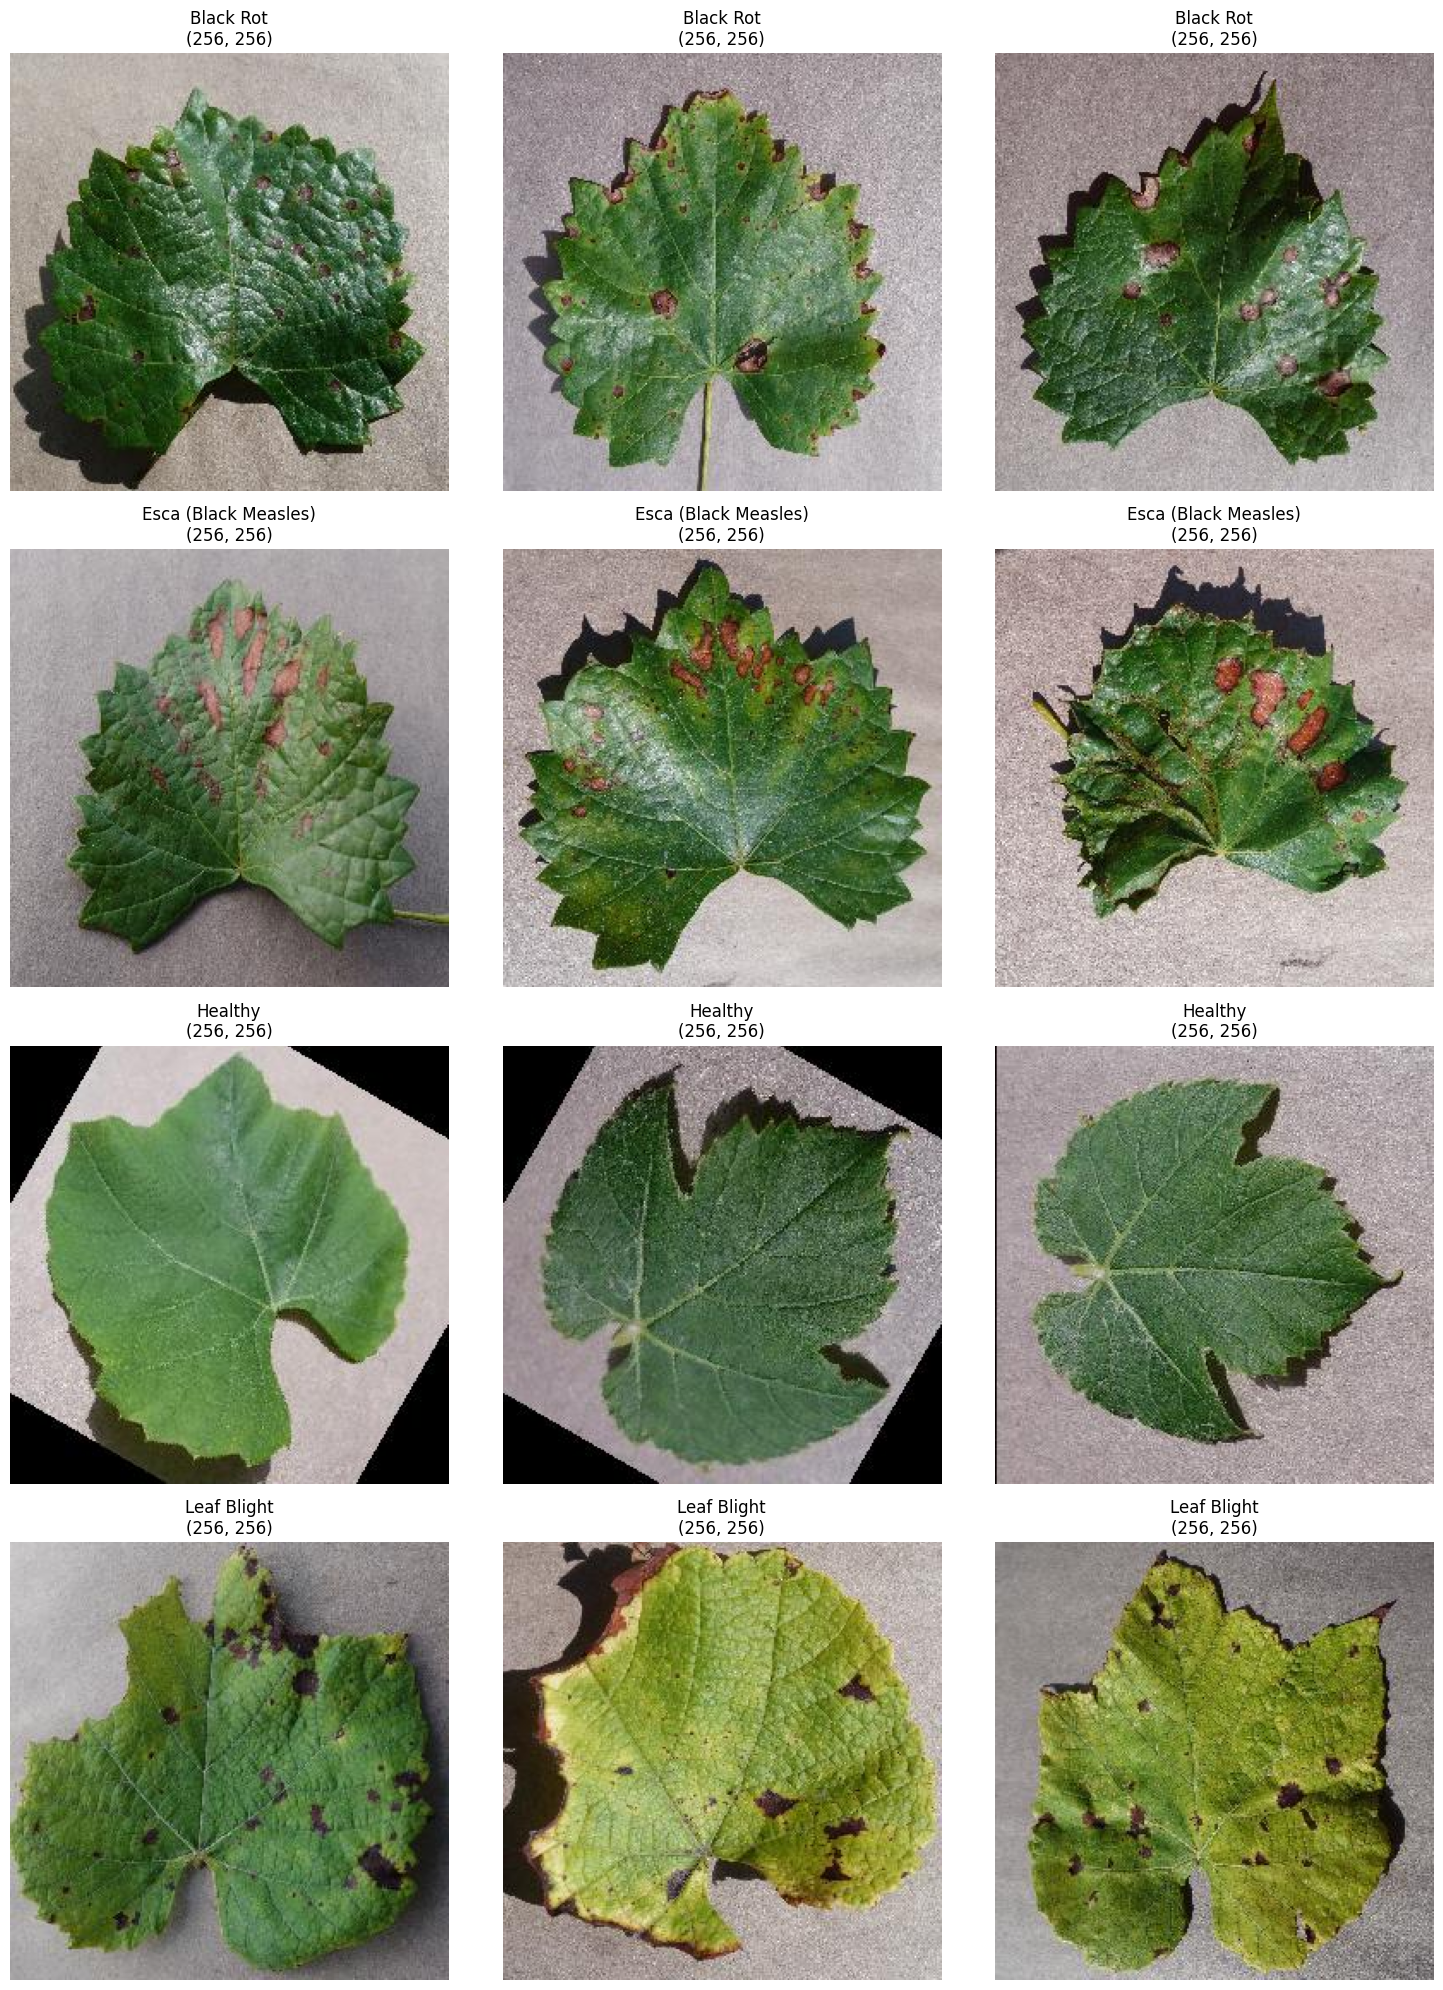

In [6]:
# Display sample images before preprocessing
try:
    display_sample_images(selected_dir_path, disease_categories)
except Exception as e:
    logger.error(f"Error displaying sample images: {str(e)}")

In [7]:
# Loading images and labels with validation and progress tracking
images = []
labels = []
image_paths = []  # Store paths for reference
target_size = (224, 224)

In [8]:
try:
    total_images = sum([len(os.listdir(os.path.join(selected_dir_path, label))) 
                       for label in disease_categories])
    processed_images = 0
    
    for label in disease_categories:
        label_path = os.path.join(selected_dir_path, label)
        
        if os.path.isdir(label_path):
            logger.info(f"Processing category: {label}")
            
            for img_name in os.listdir(label_path):
                processed_images += 1
                
                if processed_images % 100 == 0:
                    logger.info(f"Processed {processed_images}/{total_images} images")
                
                img_path = os.path.join(label_path, img_name)
                image_paths.append(img_path)
                
                try:
                    img = Image.open(img_path)
                    
                    # Check if the image is valid
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    
                    # Resize the image
                    img = img.resize(target_size)
                    
                    # Normalize pixel values
                    img_array = np.array(img) / 255.0
                    
                    images.append(img_array)
                    labels.append(label)
                except Exception as img_error:
                    logger.warning(f"Error processing image {img_path}: {str(img_error)}")
                    continue
    
    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    logger.info(f"Successfully loaded {len(images)} images with {len(np.unique(labels))} unique labels")
    print(f"Image array shape: {images.shape}")
    print(f"Labels: {np.unique(labels, return_counts=True)}")
except Exception as e:
    logger.error(f"Error in image loading process: {str(e)}")
    raise

2025-03-30 11:50:35,209 - INFO - Processing category: Black Rot
2025-03-30 11:50:36,559 - INFO - Processed 100/7335 images
2025-03-30 11:50:37,815 - INFO - Processed 200/7335 images
2025-03-30 11:50:39,048 - INFO - Processed 300/7335 images
2025-03-30 11:50:40,323 - INFO - Processed 400/7335 images
2025-03-30 11:50:41,604 - INFO - Processed 500/7335 images
2025-03-30 11:50:42,920 - INFO - Processed 600/7335 images
2025-03-30 11:50:44,224 - INFO - Processed 700/7335 images
2025-03-30 11:50:45,778 - INFO - Processed 800/7335 images
2025-03-30 11:50:47,266 - INFO - Processed 900/7335 images
2025-03-30 11:50:48,674 - INFO - Processed 1000/7335 images
2025-03-30 11:50:50,100 - INFO - Processed 1100/7335 images
2025-03-30 11:50:51,585 - INFO - Processed 1200/7335 images
2025-03-30 11:50:53,046 - INFO - Processed 1300/7335 images
2025-03-30 11:50:54,298 - INFO - Processed 1400/7335 images
2025-03-30 11:50:55,545 - INFO - Processed 1500/7335 images
2025-03-30 11:50:56,821 - INFO - Processed 16

Image array shape: (7335, 224, 224, 3)
Labels: (array(['Black Rot', 'Esca (Black Measles)', 'Healthy', 'Leaf Blight'],
      dtype='<U20'), array([1944, 1920, 1749, 1722], dtype=int64))


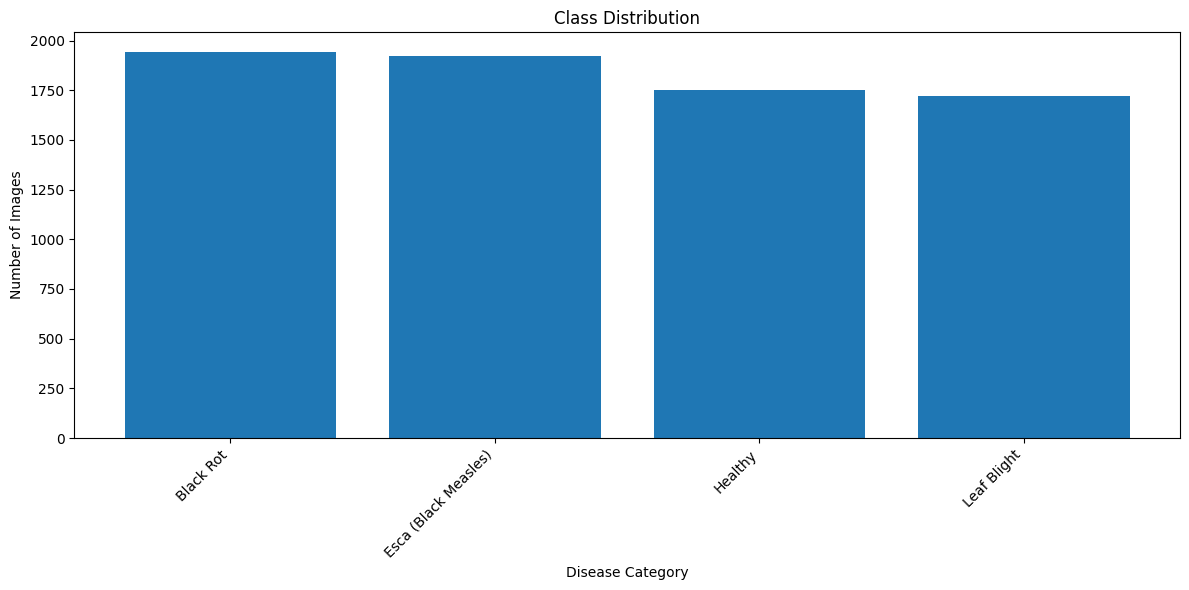

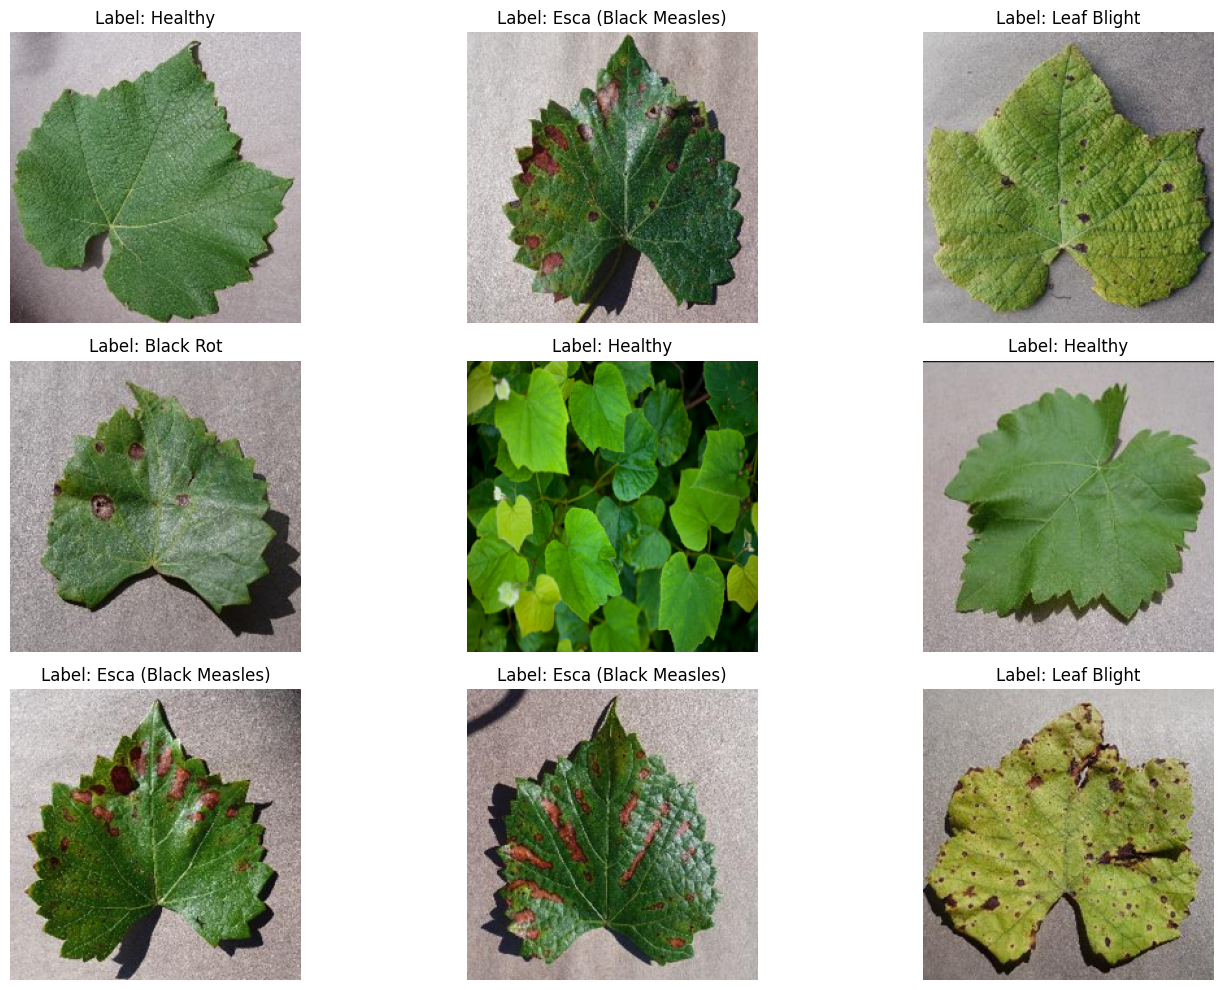

Image shape: (224, 224, 3)
Pixel value range: 0.0 to 1.0


In [9]:
# Display data distribution
try:
    # Plot class distribution
    plt.figure(figsize=(12, 6))
    label_counts = np.unique(labels, return_counts=True)
    plt.bar(label_counts[0], label_counts[1])
    plt.title('Class Distribution')
    plt.xlabel('Disease Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Display random processed images
    plt.figure(figsize=(15, 10))
    for i in range(9):
        idx = random.randint(0, len(images) - 1)
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Display image statistics
    print(f"Image shape: {images[0].shape}")
    print(f"Pixel value range: {images.min()} to {images.max()}")
except Exception as e:
    logger.error(f"Error during data validation visualization: {str(e)}")


In [10]:
# Split the dataset with validation
try:
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Verify the split
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print("")
    print(f"Training classes distribution: {np.unique(y_train, return_counts=True)}")
    print(f"Test classes distribution: {np.unique(y_test, return_counts=True)}")
    
    # Calculate and display memory usage
    def get_size_in_mb(arr):
        """Calculate the size of a numpy array in MB."""
        return arr.nbytes / (1024 * 1024)
    
    print(f"\n\nMemory usage - Training data: {get_size_in_mb(X_train):.2f} MB")
    print(f"Memory usage - Test data: {get_size_in_mb(X_test):.2f} MB")
    print(f"Total memory usage: {get_size_in_mb(images):.2f} MB")
except Exception as e:
    logger.error(f"Error during train-test split: {str(e)}")
    raise


Training set shape: (5868, 224, 224, 3)
Test set shape: (1467, 224, 224, 3)

Training classes distribution: (array(['Black Rot', 'Esca (Black Measles)', 'Healthy', 'Leaf Blight'],
      dtype='<U20'), array([1555, 1536, 1399, 1378], dtype=int64))
Test classes distribution: (array(['Black Rot', 'Esca (Black Measles)', 'Healthy', 'Leaf Blight'],
      dtype='<U20'), array([389, 384, 350, 344], dtype=int64))


Memory usage - Training data: 6739.03 MB
Memory usage - Test data: 1684.76 MB
Total memory usage: 8423.79 MB
